<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

In [0]:
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/encryption/image1.jpg')

height, width, _ = img.shape

original = cv2.resize(img, (width//8, height//8))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)

inImg = outImg = cv2.resize(gray, (width//8, height//8))

Total Pixels : 4800


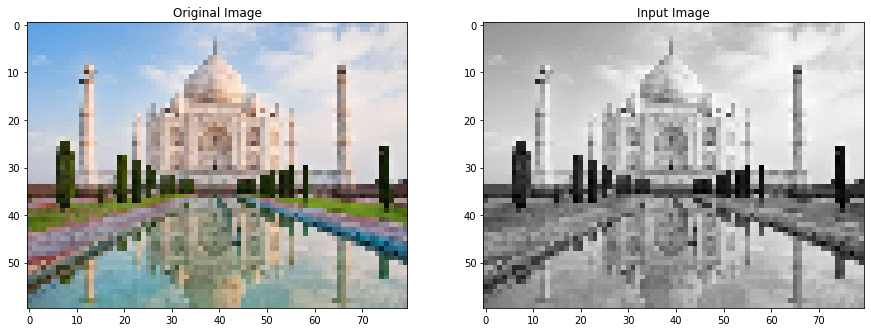

In [20]:
plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(inImg, cmap='gray')
plt.title('Input Image')

print('Total Pixels :', np.prod(inImg.shape))

In [0]:
trainSet = [[torch.Tensor(inImg), torch.Tensor(outImg)]]

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(4800, 4800)
        self.fc2 = nn.Linear(4800, 4800)        
        self.fc3 = nn.Linear(4800, 4800)        
        self.fc4 = nn.Linear(4800, 4800)        
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))        
        x = F.relu(self.fc4(x))
        
        return x

In [69]:
CONTINUE_TRAINING = False

LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 130

if not CONTINUE_TRAINING:
  net = Net()
  loss_log = []
  outputs  = []

# loss_function = nn.SmoothL1Loss()
# Define Optimizer
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


# Iteration Begins
for epoch in tqdm(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in trainSet:
        x, y = data
        x = x/255.0
        y = y/255.0

        net.zero_grad()
        
        #Compute the output
        output = net(x.view(-1, 4800))
        
        # Saving every output image
        img = output.view(60, 80)
        img = img.detach().numpy()
        outputs.append(img)

        # Compute Loss
        loss = F.smooth_l1_loss(output, y.view(-1, 4800))
        loss_log.append(loss)

        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
    # print(loss)

100%|██████████| 130/130 [02:37<00:00,  1.19s/it]


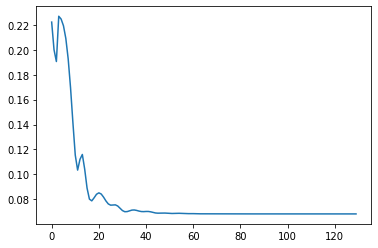

In [72]:
plt.plot(loss_log)

In [0]:
loss_log

In [73]:
for i in range(len(loss_log)):
  if loss_log[i] == loss_log[i+1]:
    print(i, loss_log[i])
    break

122 tensor(0.0682, grad_fn=<SmoothL1LossBackward>)


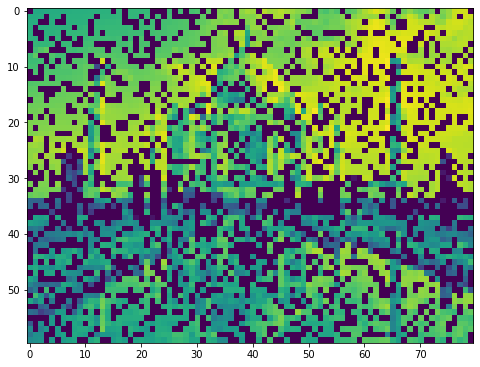

In [74]:
# Converting the tensor into numpy array and reshaping from VECTOR to 2D MATRIX
img = output.view(60, 80)
img = img.detach().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(img)

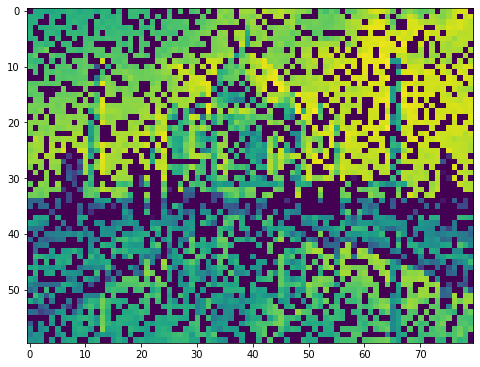

In [75]:
with torch.no_grad():
    for data in trainSet:
        x, y = data
        output = net(x.view(-1, 4800))

img = output.view(60, 80)
img = img.detach().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(img)

In [0]:
# np.save('/content/drive/My Drive/Colab Notebooks/encryption/output_images.npy', outputs[:130])
# np.save('/content/drive/My Drive/Colab Notebooks/encryption/loss_log.npy', loss_log[:130])

In [0]:
model_state = {
    'epoch': 130,
    'loss_type' : 'smooth_l1_loss',
    'loss_log' : loss_log,
    'output_images' : outputs,
    'state_dict': net.state_dict(),
    'optimizer': optimizer.state_dict(),
}

In [0]:
torch.save(model_state, f'/content/drive/My Drive/Colab Notebooks/encryption/model_state_{int(time.time())}')

In [0]:
'''
LOGS:

      Loss      |      Remarks
-------------------------------------------------
mse_loss       --> ? (worse than smooth_L1_loss)
smooth_l1_loss --> 0.0682 [learning_rate = 0.001]
kl_div         --> super bad
binary_cross_entropy_with_logits --> 0.6199
hinge_embedding_loss --> 1.0
l1_loss --> 0.2348

BEST SO FAR = smooth_l1_loss > l1_loss
'''